# Submission Tugas Explorasi ResNet
- ## Nama Kelompok : salt
- ## Nama Anggota  :  Mychael Daniel N, Fajrul Ramadhana Aqsa, Ichsan Kuntadi Baskara
- ## Nim Anggota : 122140104, 122140118 ,122140117

In [1]:
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Path folder dataset (train)
dataset_path = "/content/drive/MyDrive/deeplearning/train"

# Path file CSV
labels_csv_path = "/content/drive/MyDrive/deeplearning/train.csv"

# Nama file yang mau dihapus
target_file = "0486.jpeg"

# --- Hapus file gambar dari folder ---
file_path = os.path.join(dataset_path, target_file)
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File {target_file} berhasil dihapus dari folder.")

Mounted at /content/drive


In [2]:
# Memuat semua library yang dibutuhkan untuk proses training dan validation model
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as func
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

## test


# Pengaturan untuk menentukan device komputasi yang akan digunakan
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Untuk melihat perubahan ukuran dan jumlah parameter pada suatu arsitektur NN
!pip install torchinfo
from torchinfo import summary

# Memuat library yang akan digunakan untuk kemudahan penyimpanan ke google drive
import os

Using device: cuda


In [3]:
# Input image size untuk EfficientNetV2
size_input = 224

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(size_input, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # translasi kecil
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),   # blur ringan

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.15))
    ]),

    "val": transforms.Compose([
        transforms.Resize((size_input, size_input)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}


In [4]:
# Path folder dataset (train)
dataset_path = "/content/drive/MyDrive/deeplearning/train"
# Path file CSV
labels_csv_path = "/content/drive/MyDrive/deeplearning/train.csv"


# Memuat label dari CSV file
labels_df = pd.read_csv(labels_csv_path)

images = []
labels = []

for index, row in labels_df.iterrows():
    image_name = row['filename']
    label = row['label']
    image_path = os.path.join(dataset_path, image_name)

    try:
        img = Image.open(image_path).convert('RGB')
        images.append(img)   # simpan PIL image dulu, belum transform
        labels.append(label)
        print(f"Image has been loaded: {image_path}")
    except FileNotFoundError:
        print(f"Image file not found: {image_path}")

print(f"Loaded {len(images)} images and {len(labels)} labels.")


Image has been loaded: /content/drive/MyDrive/deeplearning/train/0001.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0002.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0003.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0004.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0005.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0006.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0007.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0008.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0009.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0010.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0011.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0012.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/0013.jpg
Image has been loaded: /content/drive/

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Image has been loaded: /content/drive/MyDrive/deeplearning/train/0999.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1000.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1001.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1002.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1003.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1004.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1005.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1006.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1007.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1008.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1009.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1010.jpg
Image has been loaded: /content/drive/MyDrive/deeplearning/train/1011.jpg
Image has been loaded: /content/drive/

In [5]:
CLASS_NAMES = ["nasi_goreng", "rendang", "soto_ayam", "bakso", "gado_gado"]
label_to_int = {label: i for i, label in enumerate(CLASS_NAMES)}
int_to_label = {i: label for label, i in label_to_int.items()}

# One-hot encoding label
encoded_labels_int = [label_to_int[label] for label in labels]
encode_labels = func.one_hot(
    torch.tensor(encoded_labels_int),
    num_classes=len(CLASS_NAMES)
)

# Split data train/val (masih dalam bentuk PIL.Image)
val_set_ratio = 0.2
train_images_raw, val_images_raw, train_labels, val_labels = train_test_split(
    images, encode_labels, test_size=val_set_ratio, random_state=67
)


# Terapkan transformasi (augmentasi targeted)
train_images_aug = []
train_labels_aug = []

for img, label in zip(train_images_raw, train_labels):
    cls_idx = torch.argmax(label).item()
    cls_name = CLASS_NAMES[cls_idx]
    # semua kelas tetap masuk dengan transformasi umum
    train_images_aug.append(data_transforms["train"](img))
    train_labels_aug.append(label)

# Val images → hanya pakai transformasi val
val_images = [data_transforms["val"](img) for img in val_images_raw]

# Buat dataset
train_set = TensorDataset(torch.stack(train_images_aug), torch.stack(train_labels_aug))
val_set   = TensorDataset(torch.stack(val_images), val_labels)

# DataLoader
batch_size = 50
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=len(val_set), shuffle=False)


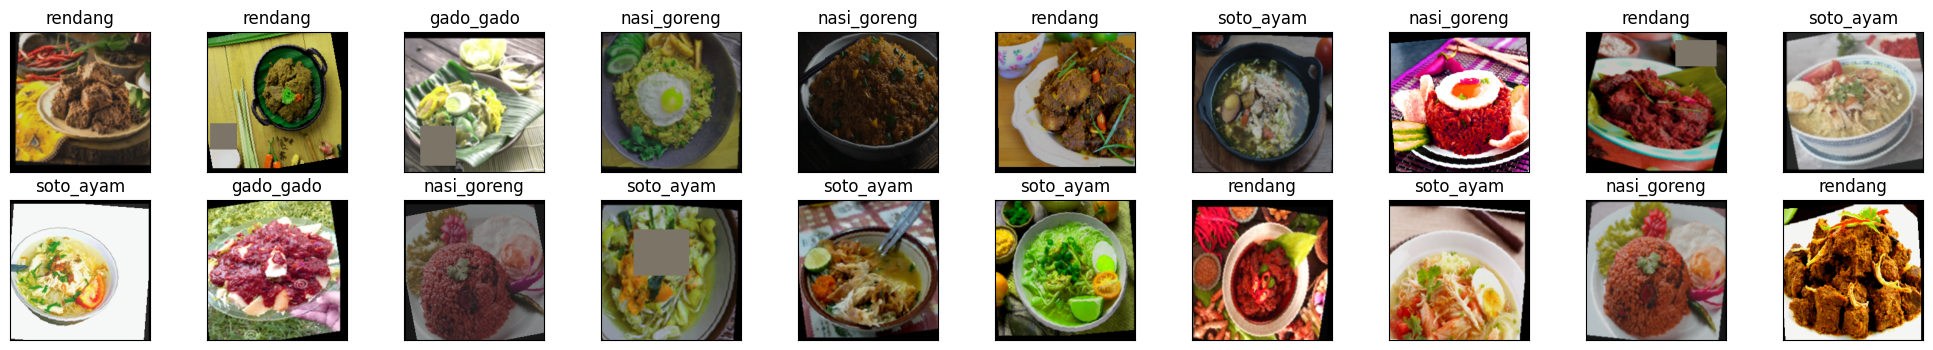

In [6]:
# Ambil batch pertama dari train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Fungsi untuk undo normalisasi ImageNet (biar warna normal)
def imshow(img):
    img = img.cpu().clone().detach().numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img = std * img + mean   # undo normalize
    img = img.clip(0, 1)
    return img

# Plot
fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

    img = imshow(images[idx])
    ax.imshow(img)

    # ambil index kelas dari one-hot
    _, labels_idx = torch.max(labels[idx], dim=0)
    ax.set_title(CLASS_NAMES[labels_idx.item()])

In [7]:
class PlainBlock(nn.Module):
    """
    Plain Block without residual connection.
    This is equivalent to a ResNet BasicBlock but without the skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(PlainBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for dimension matching (if needed)
        self.downsample = downsample

In [8]:
class PlainBlock(nn.Module):
    """
    Plain Block without residual connection.
    This is equivalent to a ResNet BasicBlock but without the skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(PlainBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for dimension matching (if needed)
        self.downsample = downsample

    def forward(self, x):
        # Store input for potential downsampling
        identity = x

        # First conv + bn + relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Second conv + bn
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply downsample to identity if needed (for dimension matching)
        if self.downsample is not None:
            identity = self.downsample(identity)

        # NO RESIDUAL CONNECTION HERE (this is the key difference from ResNet)
        # In ResNet, we would do: out += identity
        # But in Plain network, we just apply ReLU directly

        out = F.relu(out)

        return out



In [9]:
class Plain34(nn.Module):
    """
    Plain-34 Network: ResNet-34 architecture without residual connections.

    Architecture:
    - Initial conv layer (7x7, stride=2)
    - MaxPool (3x3, stride=2)
    - 4 stages of Plain blocks:
      - Stage 1: 3 blocks, 64 channels
      - Stage 2: 4 blocks, 128 channels, stride=2 for first block
      - Stage 3: 6 blocks, 256 channels, stride=2 for first block
      - Stage 4: 3 blocks, 512 channels, stride=2 for first block
    - Global Average Pool
    - Fully Connected layer
    """

    def __init__(self, num_classes=5):
        super(Plain34, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Plain block stages
        self.stage1 = self._make_stage(64, 64, 3, stride=1)    # 3 blocks, 64 channels
        self.stage2 = self._make_stage(64, 128, 4, stride=2)   # 4 blocks, 128 channels
        self.stage3 = self._make_stage(128, 256, 6, stride=2)  # 6 blocks, 256 channels
        self.stage4 = self._make_stage(256, 512, 3, stride=2)  # 3 blocks, 512 channels

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        """
        Create a stage consisting of multiple PlainBlocks.

        Args:
            in_channels: Input channels for the first block
            out_channels: Output channels for all blocks in this stage
            num_blocks: Number of blocks in this stage
            stride: Stride for the first block (usually 1 or 2)
        """
        downsample = None

        # If we need to change dimensions or stride, create downsample layer
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []

        # First block (may have stride=2 and different input/output channels)
        layers.append(PlainBlock(in_channels, out_channels, stride, downsample))

        # Remaining blocks (stride=1, same input/output channels)
        for _ in range(1, num_blocks):
            layers.append(PlainBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv + bn + relu + maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        # Plain block stages
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # Final classification layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Remove this cell after moving the methods to the class.


In [10]:

def create_plain34(num_classes=5):
    """
    Factory function to create Plain-34 model.

    Args:
        num_classes: Number of output classes (default: 5 for Indonesian food dataset)

    Returns:
        Plain34 model instance
    """
    return Plain34(num_classes=num_classes)

In [11]:
# Mendefinisikan fungsi melakukan early stopping ketika terjadi penurunan kinerja
# model terhadap validation data
def early_stopping(loss_val_history, patience, wait, thrs_error):
  early_stop = False
  if len(loss_val_history) > 1 and (loss_val_history[-2]-loss_val_history[-1])>thrs_error:
    wait += 1
    if wait >= patience:
      print("Early stopping aktif dikarenakan tidak ada peningkatan dalam validation loss untuk {} epoch.".format(patience))
      early_stop = True
    else:
      print("Early stopping masih berstatus menunggu, dengan jumlah wait saat ini = ", wait)
  else:
    wait = 0
  return wait, early_stop

In [12]:
# Mendefinisikan fungsi untuk menyimpan model dan beberapa informasi ke drive atau
# ruang penyimpanan eksternal
def save_model(model, path_folder, epoch, train_loss_epoch, val_loss_epoch):
  MODEL_NAME = "model_"+str(epoch)+".pth"
  MODEL_SAVE_PATH = os.path.join(path_folder, MODEL_NAME)
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'train_loss': train_loss_epoch,
      'val_loss': val_loss_epoch
  }, MODEL_SAVE_PATH)

In [13]:
# Mendefinisikan fungsi untuk memproses pelatihan model dengan pengujian terhadap
# validation set pada akhir epoch
def train_loop(model, train_set, val_set, optimizer, scheduler, loss_fn, num_classes,
               num_epochs, patience, fine_tuning=False):

  path_folder = "Saved_Models"
  if not os.path.exists(path_folder):
    os.makedirs(path_folder)

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  thrs_error = 0.0001
  wait = 0

  for epoch in range(num_epochs):
    # Pelatihan model dengan memanfaatkan training set dan mini-batch SGD
    model.train()
    batch_losses = []
    all_train_preds = []
    all_train_labels = []
    for batch_idx, (images, labels) in enumerate(train_set):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels.float())
      batch_losses.append(loss.detach().cpu())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)
      true_labels = torch.argmax(labels, dim=1)
      all_train_preds.extend(preds.cpu().numpy())
      all_train_labels.extend(true_labels.cpu().numpy())

    scheduler.step()

    loss_value = torch.stack(batch_losses).mean()
    train_losses.append(loss_value)
    train_acc = accuracy(torch.tensor(all_train_preds), torch.tensor(all_train_labels))
    train_accuracies.append(train_acc)


    # Pengujian kualitas model hasil pelatihan pada setiap epoch ke valdation set
    model.eval()
    with torch.no_grad():
      all_val_preds = []
      all_val_labels = []
      for batch_idx, (images, labels) in enumerate(val_set):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels.float())
        val_losses.append(loss.detach().cpu())

        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)
        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(true_labels.cpu().numpy())

      val_acc = accuracy(torch.tensor(all_val_preds), torch.tensor(all_val_labels))
      val_accuracies.append(val_acc)


    print(f"Epoch:{epoch + 1} - Loss Train={train_losses[-1]:.4f} ; Acc Train={train_accuracies[-1]:.4f} ; Loss Val={val_losses[-1]:.4f} ; Acc Val={val_accuracies[-1]:.4f}")

    # Pengecekan kondisi early stopping
    wait, early_stop = early_stopping(val_losses, patience, wait, thrs_error)
    if early_stop:
      break

    # Penyimpanan model pada setiap epoch yang akan digunakan sebagai checkpoint
    if not(fine_tuning):
      save_model(model, path_folder, epoch, train_losses[-1], val_losses[-1])

  return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
print("\n" + "="*50)
print("MODEL READY FOR TRAINING!")
print("="*50)
print("Next steps:")
print("1. Load your Indonesian food dataset")
print("2. Set up data loaders")
print("3. Define loss function and optimizer")
print("4. Train the model")
print("5. Compare with ResNet-34 (with residual connections)")



MODEL READY FOR TRAINING!
Next steps:
1. Load your Indonesian food dataset
2. Set up data loaders
3. Define loss function and optimizer
4. Train the model
5. Compare with ResNet-34 (with residual connections)


In [15]:
# Mendefinisikan fungsi untuk menghitung akurasi dari hasil prediksi
def accuracy(outputs, labels):
  # outputs and labels are expected to be 1D tensors of integer labels
  correct_predictions = (outputs == labels).sum().item()
  total_predictions = len(labels)
  return torch.tensor(correct_predictions / total_predictions)

In [16]:

import torch.nn.functional as F
num_classes = len(CLASS_NAMES)
# Membuat model Plain34 (tanpa residual connection)
model = Plain34(num_classes=num_classes).to(device)

# Gunakan input_size tanpa batch_size
# Tampilkan summary untuk model Plain34
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Plain34                                  [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─MaxPool2d: 1-3                         [1, 64, 56, 56]           --
├─Sequential: 1-4                        [1, 64, 56, 56]           --
│    └─PlainBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─PlainBlock: 2-2                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-6             [1, 64, 56, 56]           

In [17]:
# Mendefinisikan beberapa variabel dan fungsi untuk membantu proses pelatihan model
num_epochs = 30
patience = 10
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0006, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Pemrosesan pelatihan model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_loop(model, train_loader, val_loader,
                                                  optimizer, scheduler, loss_fn,
                                                  num_classes, num_epochs, patience)

Epoch:1 - Loss Train=1.6230 ; Acc Train=0.2407 ; Loss Val=7.6156 ; Acc Val=0.1306
Epoch:2 - Loss Train=1.5963 ; Acc Train=0.2520 ; Loss Val=1.5827 ; Acc Val=0.2252
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  1
Epoch:3 - Loss Train=1.5935 ; Acc Train=0.2520 ; Loss Val=1.6498 ; Acc Val=0.2342
Epoch:4 - Loss Train=1.5915 ; Acc Train=0.2418 ; Loss Val=1.5595 ; Acc Val=0.2658
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  1
Epoch:5 - Loss Train=1.5717 ; Acc Train=0.2757 ; Loss Val=1.6883 ; Acc Val=0.1802
Epoch:6 - Loss Train=1.5071 ; Acc Train=0.3424 ; Loss Val=1.4660 ; Acc Val=0.4369
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  1
Epoch:7 - Loss Train=1.4775 ; Acc Train=0.3627 ; Loss Val=1.4305 ; Acc Val=0.3694
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  2
Epoch:8 - Loss Train=1.4546 ; Acc Train=0.3661 ; Loss Val=1.4149 ; Acc Val=0.3604
Early stopping masih berstatus menunggu, dengan 

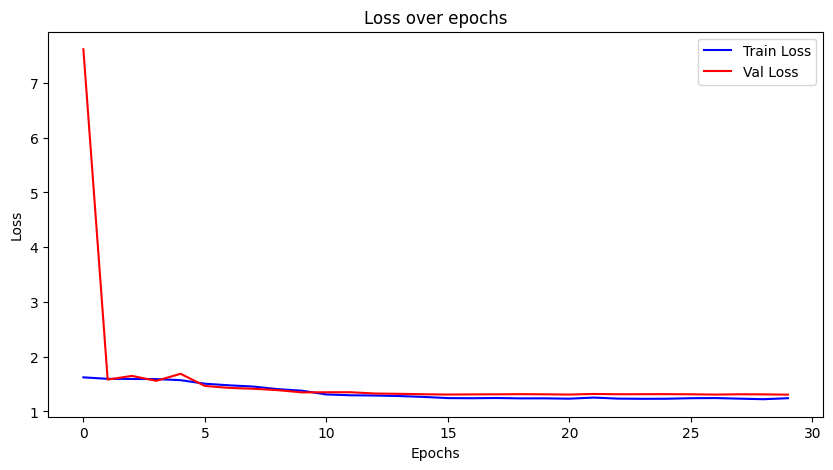

In [18]:
# Melakukan plot kualitas model (loss) vs training epochs
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, '-', color='blue', label='Train Loss')
plt.plot(val_loss_history, '-', color='red', label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)  # karena one-hot

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# === Metrik evaluasi ===
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

 nasi_goreng       0.39      0.53      0.45        45
     rendang       0.60      0.94      0.73        35
   soto_ayam       0.39      0.63      0.48        46
       bakso       0.73      0.31      0.44        51
   gado_gado       0.40      0.09      0.15        45

    accuracy                           0.48       222
   macro avg       0.50      0.50      0.45       222
weighted avg       0.50      0.48      0.44       222

Confusion Matrix:
[[24 10  6  1  4]
 [ 1 33  0  1  0]
 [ 9  4 29  2  2]
 [12  4 19 16  0]
 [15  4 20  2  4]]


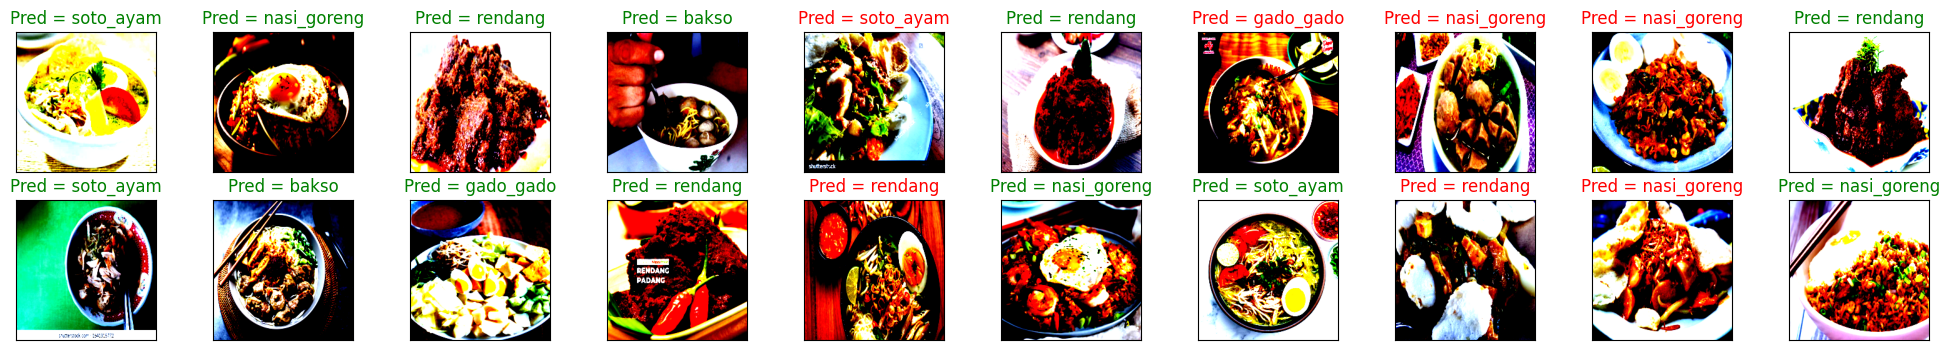

In [20]:
# Mencoba inference untuk satu batch pada val set
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)

model.eval()
with torch.inference_mode():
  y_pred = model(images)
  value, labels_pred = torch.max(y_pred, dim=1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  image = images[idx].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  plt.imshow(image)

  value, labels_idx = torch.max(labels[idx], dim=0)
  ax.set_title("Pred = {}".format(CLASS_NAMES[labels_pred[idx]]),
               color=("green" if labels_idx==labels_pred[idx] else "red"))

# TAHAP 2 MENJADI RESNET-34

In [21]:
class ResNetBasicBlock(nn.Module):
    """
    ResNet BasicBlock with residual connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBasicBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer for dimension matching (if needed)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        # Store input for residual connection
        identity = x

        # First conv + bn + relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        # Second conv + bn
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply downsample to identity if needed
        if self.downsample is not None:
            identity = self.downsample(identity)

        # Add residual connection
        out += identity

        # Apply ReLU after adding residual
        out = F.relu(out)

        return out

In [22]:
class ResNet34(nn.Module):
    """
    ResNet-34 Network with residual connections.

    Architecture:
    - Initial conv layer (7x7, stride=2)
    - MaxPool (3x3, stride=2)
    - 4 stages of Basic blocks:
      - Stage 1: 3 blocks, 64 channels
      - Stage 2: 4 blocks, 128 channels, stride=2 for first block
      - Stage 3: 6 blocks, 256 channels, stride=2 for first block
      - Stage 4: 3 blocks, 512 channels, stride=2 for first block
    - Global Average Pool
    - Fully Connected layer
    """

    def __init__(self, num_classes=5):
        super(ResNet34, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet block stages using ResNetBasicBlock
        self.stage1 = self._make_stage(64, 64, 3, stride=1)    # 3 blocks, 64 channels
        self.stage2 = self._make_stage(64, 128, 4, stride=2)   # 4 blocks, 128 channels
        self.stage3 = self._make_stage(128, 256, 6, stride=2)  # 6 blocks, 256 channels
        self.stage4 = self._make_stage(256, 512, 3, stride=2)  # 3 blocks, 512 channels

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        """
        Create a stage consisting of multiple ResNetBasicBlocks.

        Args:
            in_channels: Input channels for the first block
            out_channels: Output channels for all blocks in this stage
            num_blocks: Number of blocks in this stage
            stride: Stride for the first block (usually 1 or 2)
        """
        downsample = None

        # If we need to change dimensions or stride, create downsample layer
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []

        # First block (may have stride=2 and different input/output channels)
        layers.append(ResNetBasicBlock(in_channels, out_channels, stride, downsample))

        # Remaining blocks (stride=1, same input/output channels)
        for _ in range(1, num_blocks):
            layers.append(ResNetBasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv + bn + relu + maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        # ResNet block stages
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # Final classification layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [23]:
def create_resnet34(num_classes=5):
    return ResNet34(num_classes=num_classes)


In [24]:
# Mendefinisikan fungsi untuk menyimpan model dan beberapa informasi ke drive atau
# ruang penyimpanan eksternal
def save_model(model, path_folder, epoch, train_loss_epoch, val_loss_epoch):
  MODEL_NAME = "model_resnet"+str(epoch)+".pth"
  MODEL_SAVE_PATH = os.path.join(path_folder, MODEL_NAME)
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'train_loss': train_loss_epoch,
      'val_loss': val_loss_epoch
  }, MODEL_SAVE_PATH)

In [25]:
# Mendefinisikan fungsi untuk memproses pelatihan model dengan pengujian terhadap
# validation set pada akhir epoch
def train_loop(model, train_set, val_set, optimizer, scheduler, loss_fn, num_classes,
               num_epochs, patience, fine_tuning=False):

  path_folder = "Saved_Models"
  if not os.path.exists(path_folder):
    os.makedirs(path_folder)

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  thrs_error = 0.0001
  wait = 0

  for epoch in range(num_epochs):
    # Pelatihan model dengan memanfaatkan training set dan mini-batch SGD
    model.train()
    batch_losses = []
    all_train_preds = []
    all_train_labels = []
    for batch_idx, (images, labels) in enumerate(train_set):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels.float())
      batch_losses.append(loss.detach().cpu())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)
      true_labels = torch.argmax(labels, dim=1)
      all_train_preds.extend(preds.cpu().numpy())
      all_train_labels.extend(true_labels.cpu().numpy())

    scheduler.step()

    loss_value = torch.stack(batch_losses).mean()
    train_losses.append(loss_value)
    train_acc = accuracy(torch.tensor(all_train_preds), torch.tensor(all_train_labels))
    train_accuracies.append(train_acc)


    # Pengujian kualitas model hasil pelatihan pada setiap epoch ke valdation set
    model.eval()
    with torch.no_grad():
      all_val_preds = []
      all_val_labels = []
      for batch_idx, (images, labels) in enumerate(val_set):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels.float())
        val_losses.append(loss.detach().cpu())

        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)
        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(true_labels.cpu().numpy())

      val_acc = accuracy(torch.tensor(all_val_preds), torch.tensor(all_val_labels))
      val_accuracies.append(val_acc)


    print(f"Epoch:{epoch + 1} - Loss Train={train_losses[-1]:.4f} ; Acc Train={train_accuracies[-1]:.4f} ; Loss Val={val_losses[-1]:.4f} ; Acc Val={val_accuracies[-1]:.4f}")

    # Pengecekan kondisi early stopping
    wait, early_stop = early_stopping(val_losses, patience, wait, thrs_error)
    if early_stop:
      break

    # Penyimpanan model pada setiap epoch yang akan digunakan sebagai checkpoint
    if not(fine_tuning):
      save_model(model, path_folder, epoch, train_losses[-1], val_losses[-1])

  return train_losses, val_losses, train_accuracies, val_accuracies

In [26]:
# Mendefinisikan fungsi untuk menghitung akurasi dari hasil prediksi
def accuracy(outputs, labels):
  # outputs and labels are expected to be 1D tensors of integer labels
  correct_predictions = (outputs == labels).sum().item()
  total_predictions = len(labels)
  return torch.tensor(correct_predictions / total_predictions)

In [27]:
num_classes = len(CLASS_NAMES)

# Membuat model ResNet34 (dengan residual connection)
model = ResNet34(num_classes=num_classes).to(device)

# Gunakan input_size tanpa batch_size
# Tampilkan summary untuk model Plain34
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet34                                 [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─MaxPool2d: 1-3                         [1, 64, 56, 56]           --
├─Sequential: 1-4                        [1, 64, 56, 56]           --
│    └─ResNetBasicBlock: 2-1             [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─ResNetBasicBlock: 2-2             [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-5                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-6             [1, 64, 56, 56]           

In [28]:
# Mendefinisikan beberapa variabel dan fungsi untuk membantu proses pelatihan model
num_epochs = 30
patience = 10
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0006, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Pemrosesan pelatihan model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_loop(model, train_loader, val_loader,
                                                  optimizer, scheduler, loss_fn,
                                                  num_classes, num_epochs, patience)

Epoch:1 - Loss Train=1.6453 ; Acc Train=0.2723 ; Loss Val=7.1109 ; Acc Val=0.1577
Epoch:2 - Loss Train=1.4717 ; Acc Train=0.3706 ; Loss Val=1.6303 ; Acc Val=0.3243
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  1
Epoch:3 - Loss Train=1.3753 ; Acc Train=0.4102 ; Loss Val=1.4967 ; Acc Val=0.3739
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  2
Epoch:4 - Loss Train=1.3380 ; Acc Train=0.4407 ; Loss Val=1.7073 ; Acc Val=0.2973
Epoch:5 - Loss Train=1.2534 ; Acc Train=0.4780 ; Loss Val=1.4130 ; Acc Val=0.4009
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  1
Epoch:6 - Loss Train=1.1301 ; Acc Train=0.5582 ; Loss Val=1.2416 ; Acc Val=0.5541
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  2
Epoch:7 - Loss Train=1.0546 ; Acc Train=0.6113 ; Loss Val=1.1593 ; Acc Val=0.5811
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  3
Epoch:8 - Loss Train=1.0028 ; Acc Train=0.6294 ; Loss Va

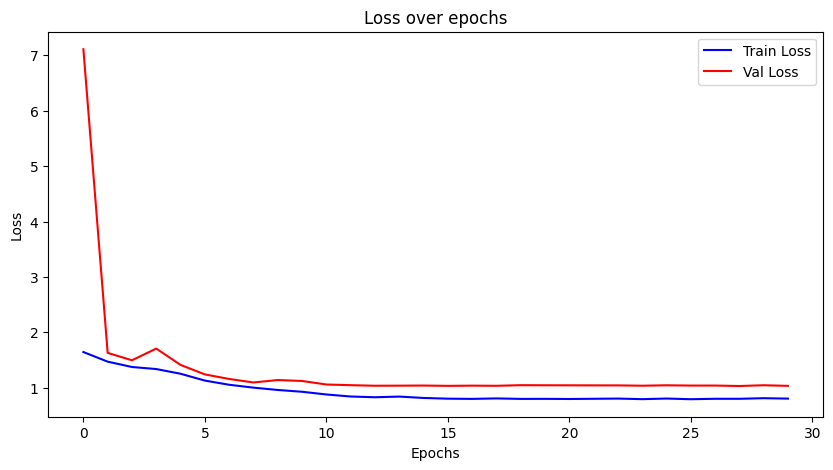

In [29]:
# Melakukan plot kualitas model (loss) vs training epochs
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, '-', color='blue', label='Train Loss')
plt.plot(val_loss_history, '-', color='red', label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)  # karena one-hot

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# === Metrik evaluasi ===
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

 nasi_goreng       0.74      0.89      0.81        45
     rendang       0.77      0.94      0.85        35
   soto_ayam       0.57      0.57      0.57        46
       bakso       0.60      0.59      0.59        51
   gado_gado       0.69      0.44      0.54        45

    accuracy                           0.67       222
   macro avg       0.67      0.69      0.67       222
weighted avg       0.67      0.67      0.66       222

Confusion Matrix:
[[40  2  1  2  0]
 [ 0 33  0  2  0]
 [ 5  2 26  8  5]
 [ 3  3 11 30  4]
 [ 6  3  8  8 20]]


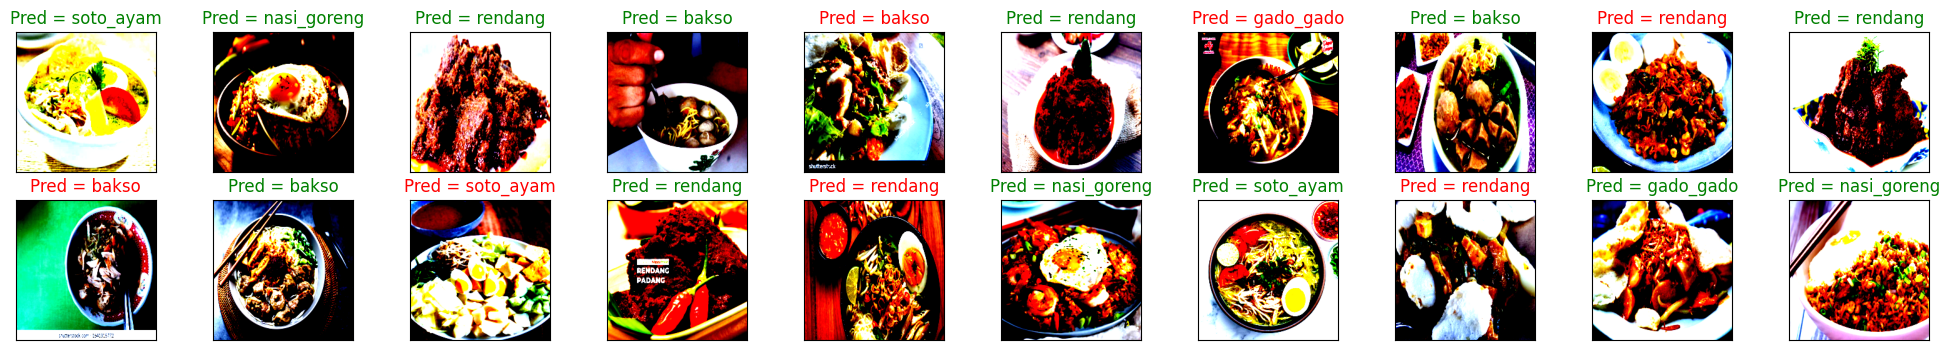

In [31]:
# Mencoba inference untuk satu batch pada val set
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)

model.eval()
with torch.inference_mode():
  y_pred = model(images)
  value, labels_pred = torch.max(y_pred, dim=1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  image = images[idx].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  plt.imshow(image)

  value, labels_idx = torch.max(labels[idx], dim=0)
  ax.set_title("Pred = {}".format(CLASS_NAMES[labels_pred[idx]]),
               color=("green" if labels_idx==labels_pred[idx] else "red"))

# TAHAP 3 MENJADI RESNET-34-Modified

In [161]:
import torch.nn.functional as F
import torch.nn as nn

# kode seblock yang cocok
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True) # Menggunakan ReLU di sini
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        # Global Average Pool (squeeze)
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        # Scale input feature maps
        return x * y.expand_as(x)


class ResNetBasicBlock(nn.Module):
    """
    ResNet BasicBlock dengan residual connection dan SEBlock, menggunakan Mish.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBasicBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # SEBlock added here
        self.se = SEBlock(out_channels) # Add SEBlock

        # Downsample layer for dimension matching (if needed)
        self.downsample = downsample
        self.stride = stride
        self.mish = nn.Mish() # Menggunakan Mish

    def forward(self, x):
        # Store input for residual connection
        identity = x

        # First conv + bn + mish
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.mish(out) # Menggunakan Mish

        # Second conv + bn
        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SEBlock
        out = self.se(out) # Apply SEBlock after the second conv+bn

        # Apply downsample to identity if needed
        if self.downsample is not None:
            identity = self.downsample(identity)

        # Add residual connection
        out += identity

        # Apply Mish after adding residual
        out = self.mish(out) # Menggunakan Mish

        return out


class ResNet34modified(nn.Module):
    """
    ResNet-34 Network with residual connections and a simplified classifier, using Mish in basic blocks and SEBlocks.

    Architecture:
    - Initial conv layer (7x7, stride=2)
    - MaxPool (3x3, stride=2)
    - 4 stages of Basic blocks (using Mish and SEBlocks):
      - Stage 1: 3 blocks, 64 channels
      - Stage 2: 4 blocks, 128 channels, stride=2 for first block
      - Stage 3: 6 blocks, 256 channels, stride=2 for first block
      - Stage 4: 3 blocks, 512 channels, stride=2 for first block
    - Global Average Pool
    - Simplified Fully Connected layer with a consistent activation (e.g., LeakyReLU or SiLU).
    """

    def __init__(self, num_classes=5):
        super(ResNet34modified, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Aktivasi Mish setelah BN1
        self.mish = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        # ResNet block stages using ResNetBasicBlock (using Mish and SEBlocks)
        self.stage1 = self._make_stage(64, 64, 3, stride=1)    # 3 blocks, 64 channels
        self.stage2 = self._make_stage(64, 128, 4, stride=2)   # 4 blocks, 128 channels
        self.stage3 = self._make_stage(128, 256, 6, stride=2)  # 6 blocks, 256 channels
        self.stage4 = self._make_stage(256, 512, 3, stride=2)  # 3 blocks, 512 channels

        # Global Average Pool
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Simplified classifier layers using LeakyReLU consistently
        self.classifier = nn.Sequential(
            nn.Linear(512, 512), # Reduce hidden layer size
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1), # Using LeakyReLU
            nn.Dropout(0.4), # Adjust dropout

            nn.Linear(512, num_classes) # Final output layer
        )

        # Initialize weights
        self._initialize_weights()


    def forward(self, x):
        # Initial conv + bn + mish + maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.mish(x) # Menggunakan Mish
        x = self.maxpool(x)

        # ResNet block stages (using Mish and SEBlocks)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        # Global Average Pool
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Classifier layers
        out = self.classifier(x)

        return out

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        """
        Create a stage consisting of multiple ResNetBasicBlocks (using Mish and SEBlocks).

        Args:
            in_channels: Input channels for the first block
            out_channels: Output channels for all blocks in this stage
            num_blocks: Number of blocks in this stage
            stride: Stride for the first block (usually 1 or 2)
        """
        downsample = None

        # If we need to change dimensions or stride, create downsample layer
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []

        # First block (may have stride=2 and different input/output channels)
        layers.append(ResNetBasicBlock(in_channels, out_channels, stride, downsample))

        # Remaining blocks (stride=1, same input/output channels)
        for _ in range(1, num_blocks):
            layers.append(ResNetBasicBlock(out_channels, out_channels)) # BasicBlocks menggunakan Mish dan SEBlock di dalamnya

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize model weights using He initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # Check if bias exists before initializing
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                # Check if bias exists before initializing
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [162]:
def create_ResNet34modified(num_classes=5):
    return ResNet34modified(num_classes=num_classes)


In [163]:
# Mendefinisikan fungsi untuk menyimpan model dan beberapa informasi ke drive atau
# ruang penyimpanan eksternal
def save_model(model, path_folder, epoch, train_loss_epoch, val_loss_epoch):
  MODEL_NAME = "model_resnet"+str(epoch)+".pth"
  MODEL_SAVE_PATH = os.path.join(path_folder, MODEL_NAME)
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'train_loss': train_loss_epoch,
      'val_loss': val_loss_epoch
  }, MODEL_SAVE_PATH)

In [164]:
# Mendefinisikan fungsi untuk memproses pelatihan model dengan pengujian terhadap
# validation set pada akhir epoch
def train_loop(model, train_set, val_set, optimizer, scheduler, loss_fn, num_classes,
               num_epochs, patience, fine_tuning=False):

  path_folder = "Saved_Models"
  if not os.path.exists(path_folder):
    os.makedirs(path_folder)

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  thrs_error = 0.0001
  wait = 0

  for epoch in range(num_epochs):
    # Pelatihan model dengan memanfaatkan training set dan mini-batch SGD
    model.train()
    batch_losses = []
    all_train_preds = []
    all_train_labels = []
    for batch_idx, (images, labels) in enumerate(train_set):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels.float())
      batch_losses.append(loss.detach().cpu())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)
      true_labels = torch.argmax(labels, dim=1)
      all_train_preds.extend(preds.cpu().numpy())
      all_train_labels.extend(true_labels.cpu().numpy())

    scheduler.step()

    loss_value = torch.stack(batch_losses).mean()
    train_losses.append(loss_value)
    train_acc = accuracy(torch.tensor(all_train_preds), torch.tensor(all_train_labels))
    train_accuracies.append(train_acc)


    # Pengujian kualitas model hasil pelatihan pada setiap epoch ke valdation set
    model.eval()
    with torch.no_grad():
      all_val_preds = []
      all_val_labels = []
      for batch_idx, (images, labels) in enumerate(val_set):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels.float())
        val_losses.append(loss.detach().cpu())

        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)
        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(true_labels.cpu().numpy())

      val_acc = accuracy(torch.tensor(all_val_preds), torch.tensor(all_val_labels))
      val_accuracies.append(val_acc)


    print(f"Epoch:{epoch + 1} - Loss Train={train_losses[-1]:.4f} ; Acc Train={train_accuracies[-1]:.4f} ; Loss Val={val_losses[-1]:.4f} ; Acc Val={val_accuracies[-1]:.4f}")

    # Pengecekan kondisi early stopping
    wait, early_stop = early_stopping(val_losses, patience, wait, thrs_error)
    if early_stop:
      break

    # Penyimpanan model pada setiap epoch yang akan digunakan sebagai checkpoint
    if not(fine_tuning):
      save_model(model, path_folder, epoch, train_losses[-1], val_losses[-1])

  return train_losses, val_losses, train_accuracies, val_accuracies

In [165]:
# Mendefinisikan fungsi untuk menghitung akurasi dari hasil prediksi
def accuracy(outputs, labels):
  # outputs and labels are expected to be 1D tensors of integer labels
  correct_predictions = (outputs == labels).sum().item()
  total_predictions = len(labels)
  return torch.tensor(correct_predictions / total_predictions)

In [166]:
# Membuat model ResNet34 modified (dengan residual connection dan classifier baru)
model = ResNet34modified(num_classes=num_classes).to(device)

# Tampilkan summary untuk memastikan arsitektur classifier sudah berubah
print("Summary of the updated model:")
summary(model, input_size=(1, 3, 224, 224))

Summary of the updated model:


Layer (type:depth-idx)                   Output Shape              Param #
ResNet34modified                         [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─Mish: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─ResNetBasicBlock: 2-1             [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Mish: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─SEBlock: 3-6                 [1, 64, 56, 56]           512


In [167]:
# Mendefinisikan beberapa variabel dan fungsi untuk membantu proses pelatihan model
num_epochs = 30
patience = 10
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0006, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Pemrosesan pelatihan model
print("\n" + "="*50)
print("STARTING TRAINING WITH UPDATED RESNET34modified MODEL!")
print("="*50)

train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_loop(model, train_loader, val_loader,
                                                  optimizer, scheduler, loss_fn,
                                                  num_classes, num_epochs, patience)


STARTING TRAINING WITH UPDATED RESNET34modified MODEL!
Epoch:1 - Loss Train=1.5488 ; Acc Train=0.3107 ; Loss Val=6.8512 ; Acc Val=0.1937
Epoch:2 - Loss Train=1.4406 ; Acc Train=0.3808 ; Loss Val=2.0816 ; Acc Val=0.3063
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  1
Epoch:3 - Loss Train=1.3453 ; Acc Train=0.4147 ; Loss Val=1.9082 ; Acc Val=0.2117
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  2
Epoch:4 - Loss Train=1.3066 ; Acc Train=0.4429 ; Loss Val=1.5993 ; Acc Val=0.3649
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  3
Epoch:5 - Loss Train=1.2326 ; Acc Train=0.4847 ; Loss Val=1.5759 ; Acc Val=0.3559
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  4
Epoch:6 - Loss Train=1.2160 ; Acc Train=0.5040 ; Loss Val=1.4629 ; Acc Val=0.4505
Early stopping masih berstatus menunggu, dengan jumlah wait saat ini =  5
Epoch:7 - Loss Train=1.0810 ; Acc Train=0.5853 ; Loss Val=1.2065 ; Acc Val=0.5225


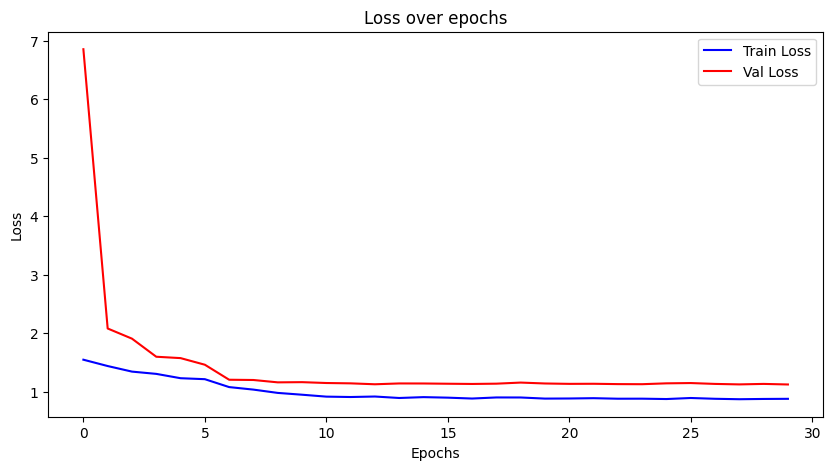

In [168]:
# Melakukan plot kualitas model (loss) vs training epochs
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, '-', color='blue', label='Train Loss')
plt.plot(val_loss_history, '-', color='red', label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

In [169]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)  # karena one-hot

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(true_labels.cpu().numpy())

# === Metrik evaluasi ===
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

 nasi_goreng       0.61      0.73      0.67        45
     rendang       0.61      0.86      0.71        35
   soto_ayam       0.53      0.65      0.58        46
       bakso       0.53      0.33      0.41        51
   gado_gado       0.37      0.24      0.29        45

    accuracy                           0.55       222
   macro avg       0.53      0.56      0.53       222
weighted avg       0.53      0.55      0.52       222

Confusion Matrix:
[[33  9  3  0  0]
 [ 2 30  0  2  1]
 [ 4  2 30  4  6]
 [ 3  4 15 17 12]
 [12  4  9  9 11]]


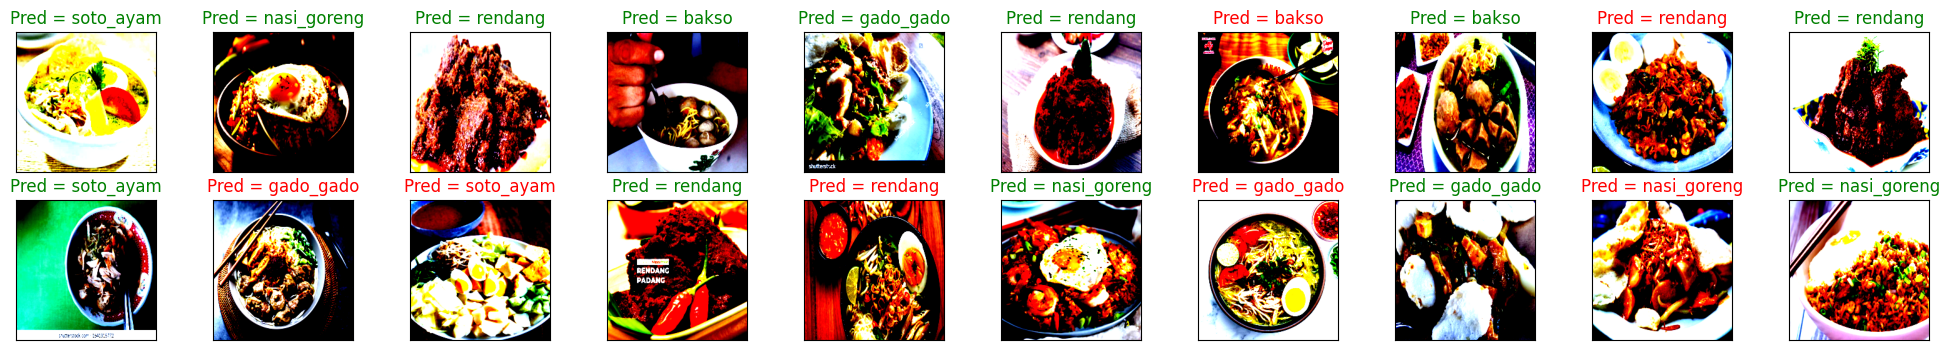

In [170]:
# Mencoba inference untuk satu batch pada val set
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)

model.eval()
with torch.inference_mode():
  y_pred = model(images)
  value, labels_pred = torch.max(y_pred, dim=1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

  image = images[idx].cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  plt.imshow(image)

  value, labels_idx = torch.max(labels[idx], dim=0)
  ax.set_title("Pred = {}".format(CLASS_NAMES[labels_pred[idx]]),
               color=("green" if labels_idx==labels_pred[idx] else "red"))